# Разработка и обучение ансамбля для предсказания инсульта


## Загрузка и предобработка данных из датасета


In [1]:
import pandas as pd
import kagglehub
import numpy as np

df_local = pd.read_csv("train(43).csv")

path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")
df_kaggle = pd.read_csv(f"{path}/healthcare-dataset-stroke-data.csv")

common_cols = list(set(df_local.columns) & set(df_kaggle.columns))
df_local = df_local[common_cols]
df_kaggle = df_kaggle[common_cols]

df = pd.concat([df_local, df_kaggle], ignore_index=True)

print("Общие колонки:", common_cols)
print("\nПропущенные значения:")

C:\Users\HONOR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Общие колонки: ['Residence_type', 'id', 'avg_glucose_level', 'age', 'heart_disease', 'bmi', 'gender', 'hypertension', 'work_type', 'stroke', 'ever_married', 'smoking_status']

Пропущенные значения:


Дальше обрабатываем данные: удаляем неинформативную колонку id, находим пропущенные значения в колонках.

In [2]:
df = df.drop(columns='id')

print(df.isnull().sum())


Residence_type           0
avg_glucose_level        0
age                      0
heart_disease            0
bmi                   1663
gender                   0
hypertension             0
work_type                0
stroke                   0
ever_married             0
smoking_status       13292
dtype: int64


дальше просматриваем колонки и определяем какие там есть признаки


In [3]:
print("\nОписание числовых признаков:")
print(df.describe())

print("\nОбзор уникальных значений и пропущенных данных:")
print(df.nunique())


Описание числовых признаков:
       avg_glucose_level           age  heart_disease           bmi  \
count       48510.000000  48510.000000   48510.000000  46847.000000   
mean          104.658132     42.324152       0.048196     28.635238   
std            43.348186     22.531358       0.214183      7.779286   
min            55.000000      0.080000       0.000000     10.100000   
25%            77.520000     24.000000       0.000000     23.300000   
50%            91.600000     44.000000       0.000000     27.800000   
75%           112.227500     60.000000       0.000000     32.900000   
max           291.050000     82.000000       1.000000     97.600000   

       hypertension        stroke  
count  48510.000000  48510.000000  
mean       0.093981      0.021274  
std        0.291805      0.144298  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000  

Обзор

Выполняем замену нечисловых признаков на числовые по таблице:
Gender: Male - 1, Female - 0
Ever_married: Yes - 1, No - 0
Smoking status: smokes - 1, formerly smoked - 0.5, never smoked - 0
Heart disease: Yes - 1, No - 0
Hypertension: Yes - 1, No - 0
Residence type: Urban - 1, Rural - 0

И one-hot для work type.


In [4]:
married_map = {'No': 0, 'Yes': 1}
residence_map = {'Rural': 0, 'Urban': 1}
smoking_map = {
    'never smoked': 0,
    'formerly smoked': 0.5,
    'smokes': 1
}
gender_map = {'Male': 1, 'Female': 0}

df['gender'] = df['gender'].map(gender_map)
df['ever_married'] = df['ever_married'].map(married_map)
df['Residence_type'] = df['Residence_type'].map(residence_map)
df['smoking_status'] = df['smoking_status'].map(smoking_map)

df = pd.get_dummies(df, columns=['work_type'], prefix='work', dummy_na=False)

Теперь вернёмся к пропущенным значениям и вставим их, посредством KNNImputer

In [5]:
from sklearn.impute import KNNImputer

numeric_df = df.select_dtypes(include=['float64', 'int64'])

imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(numeric_df)

df[numeric_df.columns] = df_imputed

print(df[['smoking_status', 'bmi']].isnull().sum())

age_median = df['age'].median()

mask = (df['age'] < age_median) & (df['heart_disease'] == 0) & (df['stroke'] == 0)

random_mask = np.random.rand(len(df)) < 0.25

final_mask = mask & random_mask

# Удаляем записи
df = df[~final_mask].reset_index(drop=True)

smoking_status    0
bmi               0
dtype: int64


Дальше проверим процентное соотношение классов по признаку stroke (0/1)

In [6]:
stroke_counts = df['stroke'].value_counts()
stroke_percent = df['stroke'].value_counts(normalize=True) * 100

print("Абсолютное количество:")
print(stroke_counts)
print("\nПроцентное соотношение:")
print(stroke_percent.round(2))


Абсолютное количество:
stroke
0.0    41551
1.0     1032
Name: count, dtype: int64

Процентное соотношение:
stroke
0.0    97.58
1.0     2.42
Name: proportion, dtype: float64


Теперь построим heat map чтобы отследить самые важные признаки в датасете

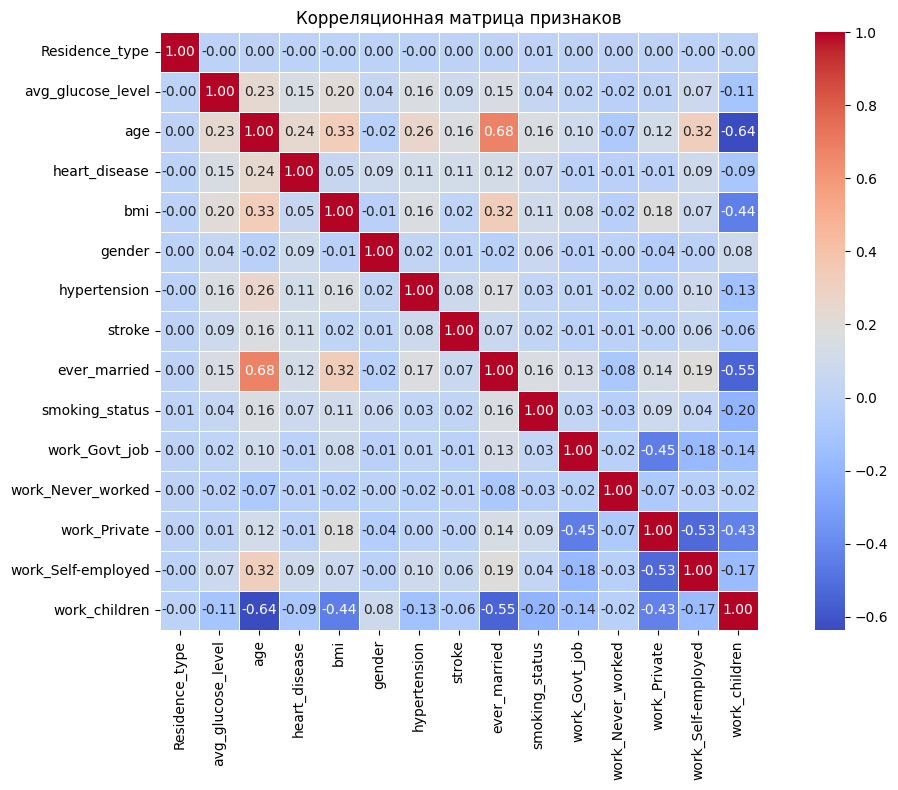

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)

plt.title("Корреляционная матрица признаков")
plt.tight_layout()
plt.show()


Мы видим явную диспропорцию классов, чего бы нам хотелось избежать, чтобы машина не отдавала предпочтения классу stroke - 0. Для этого нам лучше всего подойдёт метод SMOTE

In [8]:
from imblearn.over_sampling import SMOTE

X = df.drop(columns='stroke')
y = df['stroke']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = X_resampled.copy()
df_resampled['stroke'] = y_resampled

print(pd.Series(y_resampled).value_counts())

stroke
0.0    41551
1.0    41551
Name: count, dtype: int64


Дальше разобьём наши данные на тестовую и тренировочную выборку с соотношением 3:1 и выполним нормализацию признаков

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_resampled.drop(columns='stroke')
y = df_resampled['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


## Сборка ансамбля


Чтобы собрать ансамбль и провести обучения выберем baseline model - LogisticRegression. Это будет минимальной метрикой качества других моделей

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

baseline_model = LogisticRegression(max_iter=1000, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_index, valid_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    baseline_model.fit(X_tr, y_tr)
    preds = baseline_model.predict(X_val)
    score = accuracy_score(y_val, preds)
    scores.append(score)

print("Accuracy на каждом фолде:", scores)
print("Средняя точность baseline-модели (Logistic Regression):", np.mean(scores))


Accuracy на каждом фолде: [0.8256858655543077, 0.8195748094665062, 0.816686722823907, 0.8202166064981949, 0.8171680705976735]
Средняя точность baseline-модели (Logistic Regression): 0.8198664149881179


Теперь обучим 5 дополнительных моделей для сборки ансамбля

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf_accuracy = []
rf_f1 = []
rf_precision = []
rf_recall = []
rf_roc_auc = []

for train_index, valid_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    rf_model.fit(X_tr, y_tr)
    preds = rf_model.predict(X_val)
    probas = rf_model.predict_proba(X_val)[:, 1]

    rf_accuracy.append(accuracy_score(y_val, preds))
    rf_f1.append(f1_score(y_val, preds, average=None))           # [F1_0, F1_1]
    rf_precision.append(precision_score(y_val, preds, average=None))
    rf_recall.append(recall_score(y_val, preds, average=None))
    rf_roc_auc.append(roc_auc_score(y_val, probas))

print("Accuracy на каждом фолде (RF):", rf_accuracy)
print("Средняя Accuracy:", np.mean(rf_accuracy))

print("\nF1 по классам (0 и 1):", np.mean(rf_f1, axis=0))
print("Precision по классам (0 и 1):", np.mean(rf_precision, axis=0))
print("Recall по классам (0 и 1):", np.mean(rf_recall, axis=0))
print("Средний ROC AUC:", np.mean(rf_roc_auc))



Accuracy на каждом фолде (RF): [0.9918979624578854, 0.9935820296831127, 0.9930204572803851, 0.9919775371038909, 0.9923786602486964]
Средняя Accuracy: 0.9925713293547942

F1 по классам (0 и 1): [0.9926101  0.99253184]
Precision по классам (0 и 1): [0.9876157  0.99763505]
Recall по классам (0 и 1): [0.99765608 0.98748148]
Средний ROC AUC: 0.9985229188650667


In [12]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_scores = []

for train_index, valid_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    xgb_model.fit(X_tr, y_tr)
    preds = xgb_model.predict(X_val)
    score = accuracy_score(y_val, preds)
    xgb_scores.append(score)

print("Accuracy на каждом фолде (XGBoost):", xgb_scores)
print("Средняя точность XGBoost:", np.mean(xgb_scores))


Accuracy на каждом фолде (XGBoost): [0.9876463982031125, 0.9897312474929804, 0.9886081026875251, 0.98676293622142, 0.98676293622142]
Средняя точность XGBoost: 0.9879023241652917


In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
gb_scores = []

for train_index, valid_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    gb_model.fit(X_tr, y_tr)
    preds = gb_model.predict(X_val)
    score = accuracy_score(y_val, preds)
    gb_scores.append(score)

print("Accuracy на каждом фолде (Gradient Boosting):", gb_scores)
print("Средняя точность Gradient Boosting:", np.mean(gb_scores))


Accuracy на каждом фолде (Gradient Boosting): [0.9254772982512434, 0.9307661452065784, 0.9269153630164461, 0.9235459286000802, 0.9340553549939832]
Средняя точность Gradient Boosting: 0.9281520180136662


In [14]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lgb_scores = []

for train_index, valid_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    lgb_model.fit(X_tr, y_tr)
    preds = lgb_model.predict(X_val)
    score = accuracy_score(y_val, preds)
    lgb_scores.append(score)

print("Accuracy на каждом фолде (LightGBM):", lgb_scores)
print("Средняя точность LightGBM:", np.mean(lgb_scores))


[LightGBM] [Info] Number of positive: 24948, number of negative: 24912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 49860, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500361 -> initscore=0.001444
[LightGBM] [Info] Start training from score 0.001444
[LightGBM] [Info] Number of positive: 24942, number of negative: 24919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 49861, number of used features: 14
[LightGBM] [Info] [b

In [15]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cat_scores = []

for train_index, valid_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    cat_model.fit(X_tr, y_tr)
    preds = cat_model.predict(X_val)
    score = accuracy_score(y_val, preds)
    cat_scores.append(score)

print("Accuracy на каждом фолде (CatBoost):", cat_scores)
print("Средняя точность CatBoost:", np.mean(cat_scores))


Accuracy на каждом фолде (CatBoost): [0.986362907107332, 0.9886883273164861, 0.9897312474929804, 0.9871640593662254, 0.9870036101083033]
Средняя точность CatBoost: 0.9877900302782654


## Ансамбль


In [ ]:
from sklearn.ensemble import VotingClassifier
import joblib

logreg = joblib.load("logreg_model.pkl")
rf = joblib.load("rf_model.pkl")
xgb = joblib.load("xgb_model.pkl")

voting_ensemble = VotingClassifier(
    estimators=[('logreg', logreg), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Разделим часть данных под blending
X_blend_train, X_blend_val, y_blend_train, y_blend_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Предсказания на валидации
probs_rf = rf.predict_proba(X_blend_val)[:, 1]
probs_xgb = xgb.predict_proba(X_blend_val)[:, 1]
probs_lgb = lgb.predict_proba(X_blend_val)[:, 1]

# Собираем как признаки
blend_X = np.column_stack((probs_rf, probs_xgb, probs_lgb))

# Meta-model
meta_model = LogisticRegression()
meta_model.fit(blend_X, y_blend_val)


In [ ]:
def fusion_predict_proba(X):
    probs = []
    for model in [rf, xgb, lgb]:
        probs.append(model.predict_proba(X)[:, 1])
    avg_prob = np.mean(probs, axis=0)
    return avg_prob
